In [1]:
%matplotlib inline

In [2]:
import numpy as np

In [73]:
import matplotlib.pyplot as plt

In [74]:
from scipy.spatial.distance import pdist, squareform

In [87]:
def add_arrows(ax, scale, bc=0.3):
    for line in ax.get_lines():
        xdata = line.get_xdata()
        ydata = line.get_ydata()
        for i in range(len(xdata) - 1):
            xs = xdata[i:i+2]
            ys = ydata[i:i+2]
            xm = bc*xs[0] + (1 - bc)*xs[1]
            ym = bc*ys[0] + (1 - bc)*ys[1]
            dx = xs[1] - xs[0]
            dy = ys[1] - ys[0]
            norm = np.hypot(dx, dy)
            dx = 0.01*dx/norm
            dy = 0.01*dy/norm
            ax.arrow(xm, ym, dx, dy, head_width=scale)

In [88]:
# Todo implement this as permutation array

class Tour:

    def __init__(self, xs, ys):
        self._xs = np.asarray(xs)
        self._ys = np.asarray(ys)
        self._ix = np.arange(len(xs))
        self._dist = pdist(np.column_stack((xs, ys)))
        
    @property
    def xs(self):
        return self._xs[self._ix]
    
    @property
    def ys(self):
        return self._ys[self._ix]

    def swap(self, v0, v1):
        """ Swap two vertices in the tour.
        """
        self._ix[[v0, v1]] = self._ix[[v1, v0]]
        self._recompute_distance(v0)
        self._recompute_distance(v1)
        
    def reverse(self, v0, v1):
        """ Reverse the orientation of the tour between v0 and v1.
        """
        r = np.arange(v0, v1)
        self._ix[r] = self._ix[r[::-1]]

    def _recompute_distance(self, v):
        """ Recompute the distance between two vertices.
        """
        n = len(self._ix)
        i = (v-1) % n 
        j = (v+1) % n
        prev, vert, succ = self._ix[[i, v, j]]
        
        self._dist[[prev*vert]] = np.hypot(
            self._xs[prev] - self._xs[vert],
            self._ys[prev] - self._ys[vert]
        )
        self._dist[[succ*vert]] = np.hypot(
            self._xs[succ] - self._xs[vert],
            self._ys[succ] - self._ys[vert]
        )

    def dist(self):
        xs = np.hstack([self.xs, self.xs[0]])
        ys = np.hstack([self.ys, self.ys[0]])
        dx = xs[1:] - xs[:-1]
        dy = ys[1:] - ys[:-1]
        return np.hypot(dx, dy).sum()
        
    def plot(self, ax=None):
        if ax is None:
            _, ax = plt.subplots()
        axs = np.hstack([self.xs, self.xs[0]])
        ays = np.hstack([self.ys, self.ys[0]])
        ax.plot(axs, ays)
        ax.plot(self.xs, self.ys, 'ro')
        for i, x, y in zip(self._ix, self.xs, self.ys):
            ax.annotate(i, (x, y))
        add_arrows(ax, 0.05)
        ax.set_title(f"d = {self.dist():.03f}")

In [103]:
# def two_opt(tour, v0, v1):
#     n = len(self.xs)
#     minchange = 0
#     swap_i = swap_j = None
#     for i in range(n-2):
#         for j in range(i+2, n-1):
#             change = (self._dist[i, j] + self._dist[i+1, j+1] -
#                       self._dist[i, i+1] - self._dist[j, j+1])
#             if minchange > change:
#                 minchange = change
#                 swap_i = i
#                 swap_j = j

#     if minchange < 0:
#         self.xs[[swap_i+1, swap_j]] = self.xs[[swap_j, swap_i+1]]
#         self.ys[[swap_i+1, swap_j]] = self.ys[[swap_j, swap_i+1]]

#     return minchange, swap_i, swap_j

def two_opt(tour, v0, v1):
    tour.swap(v0+1, v1)
    tour.reverse(v0+2, v1)

In [104]:
prng = np.random.RandomState(seed=12345)

xs = prng.uniform(size=20)
ys = prng.uniform(size=20)

xs = np.array([1, 2, 3, 4, 4, 3, 2, 1])
ys = np.array([2, 2, 2, 2, 1, 1, 1, 1])

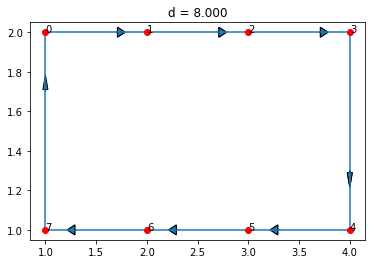

In [105]:
t = Tour(xs, ys)

t.plot()

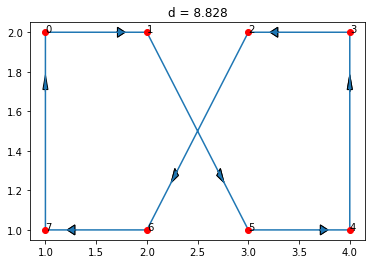

In [106]:
two_opt(t, 1, 5)
t.plot()